In [1]:
%matplotlib inline
import os
import glob
import sys
import gc
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from commons.configuration_manager import ConfigurationManager
from src.learning.training.collector import Collector
from src.learning.training.generator import GenFiles
from src.learning.training.training_file_reader import TrainingFileReader
from notebooks.notebook_commons import read_shifted_numerics_and_targets, read_stored_data_with_shifted_labels, create_memorized_dataset
from src.utilities.transformer import Transformer

In [18]:
def clean_genfile_folder(path):
    if not os.path.isdir(path):
        os.mkdir(path)
    
    old_genfiles = glob.glob(path + '*')
    for old_genfile in old_genfiles:
        os.remove(old_genfile)

def plot_stuff(title, plot_elems, bins=None, figsize=(18, 10)):
    fig=plt.figure(figsize=figsize)
    plt.title(title)
    #plt.ylabel('dunno')
    plt.xlabel('Count')
    
    for plot_elem in plot_elems:
        plt.hist(plot_elem['data'], bins=bins, **plot_elem['kwargs'])

    plt.grid(axis='both')
    plt.legend(loc='best')
    plt.show()

def half_max_thresh(counts: dict):
    return int(np.mean(counts) +  (np.max(counts) - np.mean(counts)) // 2)

def mean_thresh(counts: dict):
    return int(np.mean(counts))

def double_mean_thresh(counts: dict):
    return int(2 * np.mean(counts))
    
def downsample_indexes(data_column, sample_threshold, sampling=None, bin_start=-1.0, bin_end=1.0, bin_size=0.01):
    if sampling is None:
        downsampling = np.ones(data_column.shape, dtype=int)
    else:
        downsampling = np.copy(sampling)
    
    bins = np.arange(bin_start, bin_end, bin_size)
    indices = np.digitize(data_column, bins)
    unique_bins, counts = np.unique(indices, return_counts=True)
    sorted_counts = np.sort(counts)
    
    count_dict = dict(zip(unique_bins, counts))
    threshold_count = sample_threshold(counts)
    
    for unique_bin, count in count_dict.items():
        if count > threshold_count:
            indexes = np.where(indices == unique_bin)[0]
            to_del_indexes = np.random.choice(indexes, count - threshold_count, replace=False)
            
            downsampling[to_del_indexes] = 0
    
    return downsampling

def upsample_indexes(data_column, sampling, sample_threshold, bin_start=-1.0, bin_end=1.0, bin_size=0.01):
    upsample_multipliers = np.zeros(data_column.shape, dtype=int)
    bins = np.arange(bin_start, bin_end, bin_size)
    indices = np.digitize(data_column, bins)
    
    unique_bins, counts = np.unique(indices, return_counts=True)
    count_dict = dict(zip(unique_bins, counts))
    threshold_count = sample_threshold(counts)
    
    for i in range(0, upsample_multipliers.shape[0]):
        count = count_dict[indices[i]]
        if count >= threshold_count:
            upsample_multipliers[i] = sampling[i]
        else:
            upsample_multipliers[i] = int(threshold_count / count)
    
    return upsample_multipliers


# At current recording speed, 50 instances _should_ come up to about 5 seconds
def sample_recovery_indexes(gear_column, sampling=None, count_to_crash=20, peek_limit=100):
    if sampling is None:
        recovery_sampling = np.ones(gear_column.shape, dtype=int)
    else:
        recovery_sampling = np.copy(sampling)
    last_gear = None
    
    recovery_start = None
    recovery_end = None
    
    for index, current_gear in enumerate(gear_column):
        if last_gear is None:
            last_gear = current_gear
            continue
        
        if last_gear == 1 and current_gear == 0 and is_reversing_ahead(gear_column, index, peek_limit):
            recovery_start = index
        
        if last_gear == 0 and current_gear == 1 and is_reversing_before(gear_column, index, peek_limit):
            recovery_end = index
        
        if recovery_start is not None and recovery_end is not None:
            recovery_sampling[recovery_start:recovery_end] = 1
            
            bad_driving_start = recovery_start - count_to_crash
            if bad_driving_start >= 0:
                recovery_sampling[bad_driving_start : recovery_start] = 0
            else:
                recovery_sampling[0 : recovery_start] = 0
            
            recovery_start = None
            recovery_end = None
        
        last_gear = current_gear
    return recovery_sampling


def is_reversing_ahead(gear_column, index, peek_limit):
    end_index = index + peek_limit
    
    if end_index >= gear_column.shape[0]:
        end_index = gear_column.shape[0] - 1
        
    for i in range(index, end_index):
        if gear_column[i] == -1:
            return True
        
    return False


def is_reversing_before(gear_column, index, peek_limit):
    start_index = index - peek_limit
    
    if start_index < 0:
        start_index = 0
        
    for i in range(index, start_index, -1):
        if gear_column[i] == -1:
            return True
        
    return False


def store_sampling(new_sampling, path, filename, clean=False):
    if os.path.isfile(path + filename):
        if clean:
            os.remove(glob.glob(path + filename)[0])
            full_sampling = new_sampling
        else:
            stored_sampling = np.load(path + filename, allow_pickle=True)
            full_sampling = np.concatenate((stored_sampling, new_sampling), axis=0)
    else:
        full_sampling = new_sampling
    
    np.save(path + filename, full_sampling)

### Generate training partials

In [3]:
config_manager = ConfigurationManager()
config = config_manager.config

base_path = '../../training/'

reader = TrainingFileReader(path_to_training=base_path + 'laps/')
collector = Collector()

filenames = [fn.split('.')[0] for fn in os.listdir(base_path + 'laps/') if fn.endswith('.avi')]
#filenames = [fn.split('.')[0] for fn in os.listdir(base_path + 'laps/') if fn.endswith('.avi') and '_lap_' in fn]
#filenames = ['archived_automatic_gear/' + fn.split('.')[0] for fn in os.listdir(base_path + 'laps/archived_automatic_gear/') if fn.endswith('.avi')]
#filenames = filenames[:4]
print(filenames)

memory_variants = [(1, 1), (2, 1), (2, 2), (4, 1), (4, 2), (6, 1), (6, 2)]
memory_variants = memory_variants[:1]
augmentation = True

['2020_02_28_lap_2', '2020_02_28_lap_1', '2020_02_28_lap_7', '2020_07_07_i1', '2020_07_12_i5', '2020_02_28_lap_13', '2020_06_17_i2', '2020_06_24_i1', '2020_07_14_i2', '2020_02_28_lap_9', '2020_03_12_lap_24', '2020_06_17_i6', '2020_02_28_lap_2c', '2020_06_17_i5', '2020_02_28_lap_21', '2020_07_14_i1', '2020_02_28_lap_14', '2020_07_05_i3', '2020_02_28_lap_11', '2020_02_28_lap_15', '2020_02_28_lap_3', '2020_02_28_lap_19', '2020_02_28_lap_1c', '2020_02_28_lap_10', '2020_07_12_i4', '2020_03_12_lap_25', '2020_07_05_i2', '2020_07_14_i3', '2020_07_12_i1', '2020_03_12_lap_28', '2020_07_07_i2', '2020_02_28_lap_12', '2020_02_28_lap_18', '2020_06_28_i3', '2020_07_07_i3', '2020_07_05_i1', '2020_06_24_i6', '2020_06_17_i1', '2020_02_28_lap_20', '2020_06_28_i4', '2020_06_24_i5', '2020_03_12_lap_26', '2020_06_24_i3', '2020_06_28_i1', '2020_06_24_i4', '2020_06_28_i2', '2020_02_28_lap_23', '2020_07_08_i2', '2020_07_08_i1', '2020_02_28_lap_8', '2020_06_17_i4', '2020_03_12_lap_29', '2020_02_28_lap_16', '202

In [4]:
# Create partials for memory variants

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
generator = ImageDataGenerator()

total_diffs = {}

for memory in tqdm(memory_variants):
    total_diff = None
    transformer = Transformer(config, memory)
    
    len_diff = (memory[0] - 1) * memory[1]
    memory_string = 'n{}_m{}'.format(*memory)
    
    path = base_path + memory_string + '/'
    clean_genfile_folder(path)
    
    tqdm.write('Writing n{}_m{} files.'.format(*memory))    
    
    for filename in tqdm(filenames):
        mem_slice_frames = []
        mem_slice_numerics = []
        
        existing_count = len([fn for fn in os.listdir(path) if fn.startswith('frame_')])
        
        numerics, diffs = read_shifted_numerics_and_targets(reader, filename, collector.numeric_columns(), collector.numeric_columns())
        stored_i = 0
        
        for i, frame in reader.read_video_gen(filename + '.avi', diffs.shape[0]):
            # Augmentation
            if augmentation:
                transform_params = {'brightness': np.random.uniform(0.4, 1.3)}    
                frame = generator.apply_transform(frame, transform_params)
            
                #should_flip = np.random.uniform(0.0, 1.0) > 0.9
                #if should_flip and memory[0] == 1:
                #    transform_params['flip_horizontal'] = True
                #    numerics[i, 1] *= -1.0
                #    diffs[i, 1] *= -1.0
            
            mem_frame = transformer.session_frame_wide(frame, mem_slice_frames)
            mem_numeric = transformer.session_numeric_np(numerics[i], mem_slice_numerics)
            
            if mem_frame is None or mem_numeric is None:
                continue
            
            np.save(path + GenFiles.frame.format(memory_string, stored_i + existing_count), mem_frame)
            np.save(path + GenFiles.numeric.format(memory_string, stored_i + existing_count), mem_numeric)
            np.save(path + GenFiles.diff.format(memory_string, stored_i + existing_count), diffs[i])
            stored_i += 1
            
        if total_diff is None:
            total_diff = diffs[len_diff:].copy()
        else:
            total_diff = np.concatenate((total_diff, diffs[len_diff:].copy()))

        gc.collect()
        
    total_diffs[memory_string] = total_diff

Writing n1_m1 files.


### Generate validation partials 

In [ ]:
val_reader = TrainingFileReader(path_to_training=base_path + 'validation_laps/')

val_filenames = [fn.split('.')[0] for fn in os.listdir(base_path + 'validation_laps/') if fn.endswith('.avi') and 'validation' in fn]
print(val_filenames)

for memory in tqdm(memory_variants):
    transformer = Transformer(config, memory)
    
    len_diff = (memory[0] - 1) * memory[1]
    memory_string = 'n{}_m{}'.format(*memory)
    
    val_path = base_path + memory_string + '_val/'
    clean_genfile_folder(val_path)
    tqdm.write('Writing n{}_m{}_val files.'.format(*memory))    
    
    for filename in tqdm(val_filenames):
        mem_slice_frames = []
        mem_slice_numerics = []
        
        existing_count = len([fn for fn in os.listdir(val_path) if fn.startswith('frame_')])
        
        numerics, diffs = read_shifted_numerics_and_targets(val_reader, filename, collector.numeric_columns(), collector.numeric_columns())
        stored_i = 0
        
        for i, frame in val_reader.read_video_gen(filename + '.avi', diffs.shape[0]):
            mem_frame = transformer.session_frame_wide(frame, mem_slice_frames)
            mem_numeric = transformer.session_numeric_np(numerics[i], mem_slice_numerics)
            
            if mem_frame is None or mem_numeric is None:
                continue
            
            np.save(val_path + GenFiles.frame.format(memory_string, stored_i + existing_count), mem_frame)
            np.save(val_path + GenFiles.numeric.format(memory_string, stored_i + existing_count), mem_numeric)
            np.save(val_path + GenFiles.diff.format(memory_string, stored_i + existing_count), diffs[i])
            stored_i += 1
            
        gc.collect()

### Generate sampling files

In [8]:
# NB this is shifted steering + throttle specific
samplings = {}

for memory_string, total_diff in total_diffs.items():    
    sampling = np.ones(total_diff.shape[0])
    #sampling = downsample_indexes(total_diff[:, 2], half_max_thresh, bin_start=0.0)
    #sampling = downsample_indexes(total_diff[:, 1], half_max_thresh, sampling=sampling)
    #sampling = downsample_indexes(total_diff[:, 1], double_mean_thresh)
    #sampling = downsample_indexes(total_diff[:, 1], mean_thresh)
    sampling = sample_recovery_indexes(total_diff[:, 0], sampling=sampling)
    #sampling = upsample_indexes(total_diff[:, 1], sampling, half_max_thresh)
    #sampling = upsample_indexes(total_diff[:, 1], sampling, double_mean_thresh)
    #sampling = upsample_indexes(total_diff[:, 2], sampling, mean_thresh)
    sampling = upsample_indexes(total_diff[:, 1], sampling, mean_thresh)
    
    samplings[memory_string] = sampling
    sample_path = base_path + memory_string + '/'
    store_sampling(sampling, sample_path, GenFiles.steer_sampling.format(memory_string), clean=True)

In [ ]:
# NB this is shifted gear specific
gear_samplings = {}

for memory_string, total_diff in total_diffs.items():
    gear_sampling = np.ones(total_diff.shape[0])
    gear_sampling = downsample_indexes(total_diff[:, 0], mean_thresh, bin_start=-1, bin_end=2, bin_size=1)
    gear_sampling = upsample_indexes(total_diff[:, 0], gear_sampling, mean_thresh, bin_start=-1, bin_end=2, bin_size=1)
    
    gear_samplings[memory_string] = sampling
    sample_path = base_path + memory_string + '/'
    store_sampling(gear_sampling, sample_path, GenFiles.gear_sampling.format(memory_string), clean=True)

### Analyse sampling effects, compared to original distributions

In [9]:
memory_string = 'n1_m1'
path = base_path + memory_string + '/'

diffs = total_diffs[memory_string]
sampling = samplings[memory_string]
#gear_sampling = gear_samplings[memory_string]

print(len([fn for fn in os.listdir(path) if fn.startswith('frame_')]))
print(len([fn for fn in os.listdir(path) if fn.startswith('numeric_')]))
print(len([fn for fn in os.listdir(path) if fn.startswith('diff_')]))
print(diffs.shape)
print(sampling.shape)
#print(gear_sampling.shape)

sampled_diffs = np.repeat(diffs, sampling, axis=0)
#gear_diffs = np.repeat(diffs, gear_sampling, axis=0)

382926
382926
382926
(382926, 4)
(382926,)


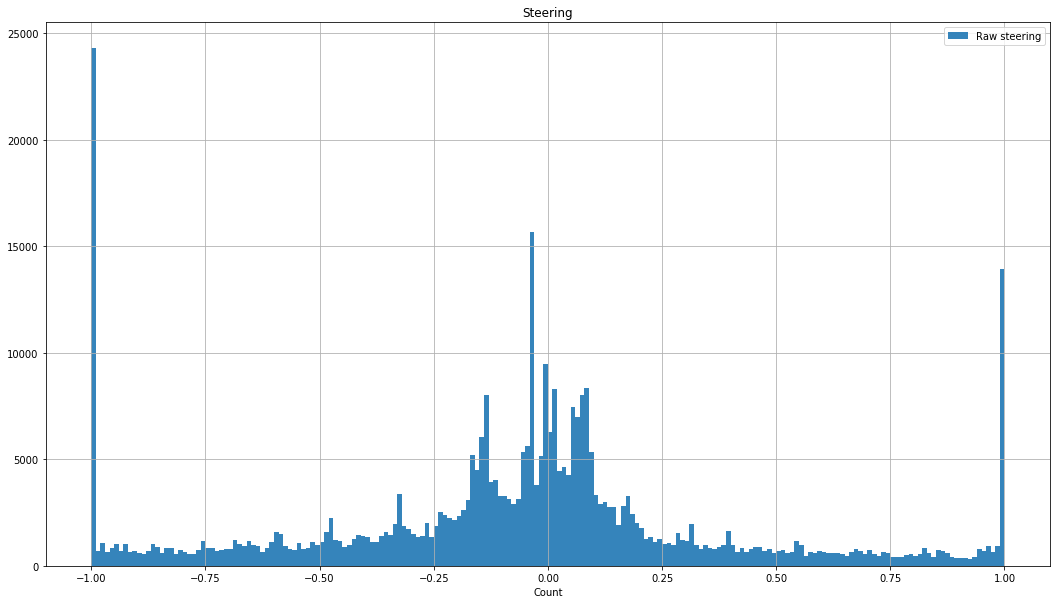

In [20]:
plot_elems = []
plot_elems.append({'data': diffs[:, 1], 'kwargs':{'label': 'Raw steering', 'alpha': 0.9}})
bins = np.arange(-1.0, 1.01, 0.01)
plot_stuff('Steering', plot_elems, bins)

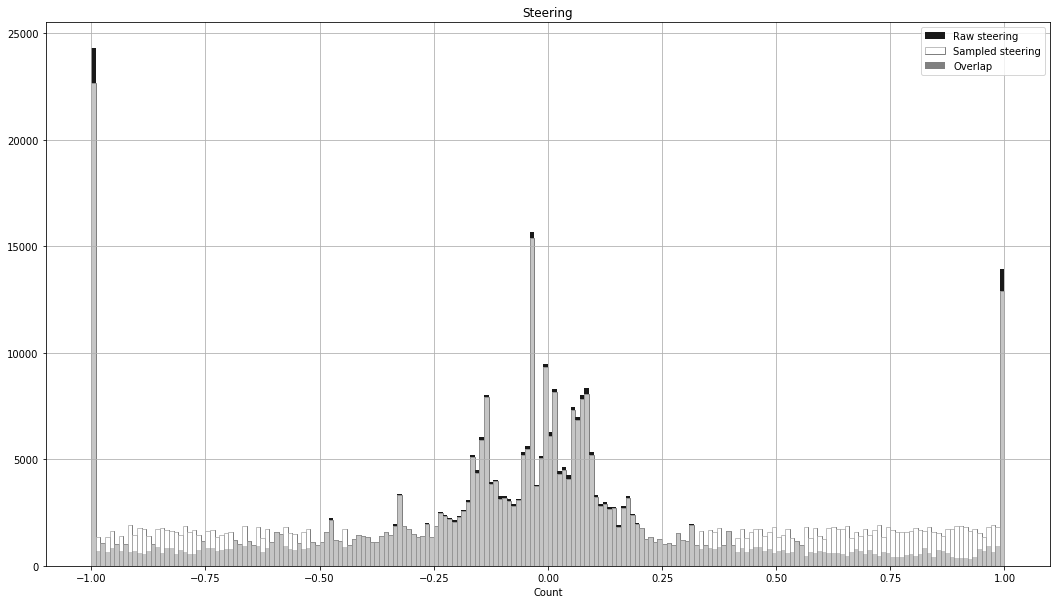

In [36]:
import matplotlib.patheffects as pe

plot_elems = []
plot_elems.append({'data': diffs[:, 1], 'kwargs':{'label': 'Raw steering', 'alpha': 0.9, 'color':'k'}})
plot_elems.append({'data': sampled_diffs[:, 1], 'kwargs':{'label': 'Sampled steering', 'alpha': 0.5, 'color':'w', 'path_effects':[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()]}})
plot_elems.append({'data': [], 'kwargs':{'label': 'Overlap', 'color':'#808080'}})
bins = np.arange(-1.0, 1.01, 0.01)
plot_stuff('Steering', plot_elems, bins)

In [ ]:
plot_elems = []
plot_elems.append({'data': diffs[:, 2], 'kwargs':{'label': 'Raw throttle', 'alpha': 0.9}})
bins = np.arange(0.0, 1.01, 0.01)
plot_stuff('Throttle', plot_elems, bins)

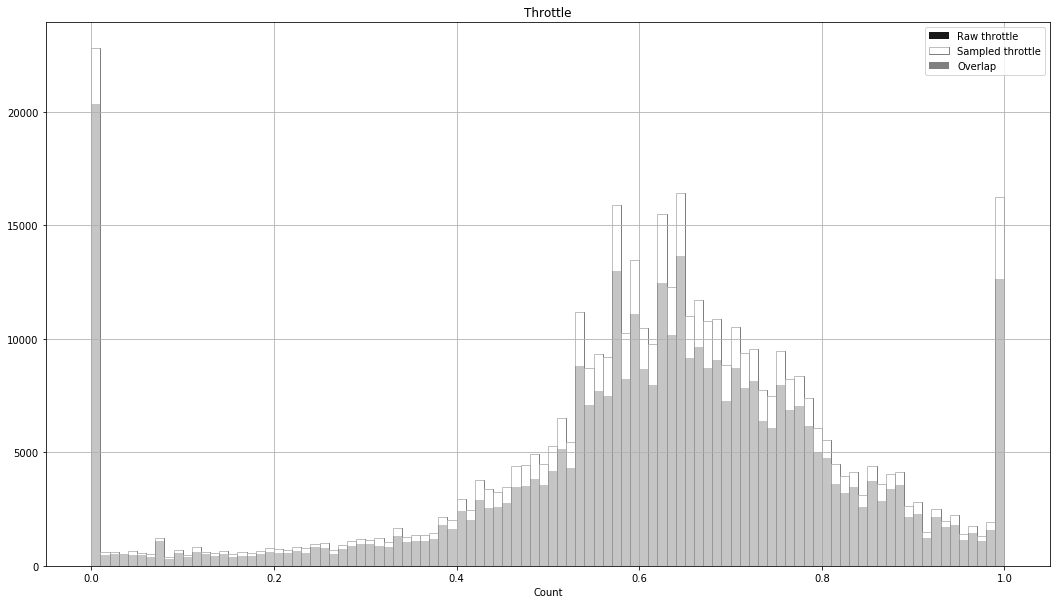

In [38]:
plot_elems = []
plot_elems.append({'data': diffs[:, 2], 'kwargs':{'label': 'Raw throttle', 'alpha': 0.9, 'color':'k'}})
plot_elems.append({'data': sampled_diffs[:, 2], 'kwargs':{'label': 'Sampled throttle', 'alpha': 0.5, 'color':'w', 'path_effects':[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()]}})
plot_elems.append({'data': [], 'kwargs':{'label': 'Overlap', 'color':'#808080'}})
bins = np.arange(0.0, 1.01, 0.01)
plot_stuff('Throttle', plot_elems, bins)

In [ ]:
plot_elems = []
plot_elems.append({'data': diffs[:, 0], 'label': 'gear', 'alpha': 0.9})
#plot_elems.append({'data': gear_diffs[:, 0], 'label': 'sampled gear', 'alpha': 0.6})
bins = np.arange(-1, 1.2, 0.1)
plot_stuff('gear', plot_elems, bins)